# COVID19 severe (hospitalized) cases in Brazil

# Univariate logistic regression

Publicly available data for hospitalized cases in Brazil is used to perform a retrospective cross-sectional observational study.

It means that we want to infer the paramaters driving the outcome from data gathered from hospitals.
The data has been downloaded, selected and preprocessed before the steps described in this notebook.

The aim is to compare different variants and infer what parameters are driving the severity and the outcome.<br>
I proceed as follow:
<ol>
    <li><strong><u> Compute some new features from the data (time between some dates, etc) and explore data </u></strong></li>
    <li> Perform univariate logistic regression</li>
            <ol><li>Perform regression (Presented in this notebook)</li><li>Show results</li></ol>
    <li> Based on the result of the univariate regression, move to a multivariate logistic regression with stepwise approach.</li>
</ol>
    
| Features in the data | Features added | Primary Outcome (Label) | Secondary Outcome |
|-|-|-|-|
| age | age group | death/cured | ICU admission |
| sex | nber of comorbidities | | ventilation (invasive/noninvasive) |
| ethnicity | nber of vaccine doses received | | |
| Federative unit (i.e., state) | delay between last dose of vaccine (if >=2) and 1st symptoms | | |
| symptoms | length of hospital stay | | |
| comorbidities | delay between 1st symptoms and hospitalization | | |
| pregnancy status | | | |

This is applied to four different periods of time when four different variants where dominant (>=80% of samples analyzed were corresponding to the variant of interest, source: GISAID database):
- Delta
- Omicron BA.1
- Omicron BA.2
- Omicron BA.4/BA.5

> **Data source**: all the data has been taken from the Brazilian Ministry of Health https://opendatasus.saude.gov.br/organization/ministerio-da-saude
>
>It requires translation from Portuguese to English

## Python module used in this notebook

In [1]:
import pandas as pd
import scipy.stats as scst
import sys
import numpy as np
import matplotlib.pyplot as plt
import os

## Parameters defined: 

- variant periods of time
- variant names
- age class (for statistics purpose)
- comorbidity list (English vs Portuguese in original data)
- ethnicity list (English vs Portuguese in original data)

In [2]:
variants_period = [['2021-09-12','2021-12-19'],['2022-01-03','2022-03-20'],['2022-04-11','2022-05-29'],
                   ['2022-07-18','2022-10-02']]
variants_name = ['Delta','BA.1.X','BA.2.X','BA.4/5.X']
file_name = ['Delta','BA1X','BA2X','BA45X']
#age_class = [[0,4],[5,9],[10,14],[15,19],[20,29],[30,39],[40,49],[50,59],[60,64],[65,69],[70,74],[75,79],[80]]
age_range = [[0,4],[5,14],[15,24],[25,44],[45,54],[55,64],[65]]
age_code = [0,1,2,3,4,5,6]
gender = ['Female','Male']
comorb_list = ['cardiovascular_disease','hematologic_disease','down_syndrom','liver_disease','asthma','diabetes',
          'neurological_disease','chronic_lung_disease','weaken_immune_system','renal_disease','obesity','puerperal',
               'other_comorbidities']
race_list = ['Indigenous','Brown','Asian','Black','White','Unknown']

## Functions

The following function compute the following features
- age group
- number of comorbidities
- number of vaccine dose received
- delay between the last dose received (if 2+ dose) and onset of symptoms (in days)
- ethnicity (translated into English)
- length of stay in the healthcare facility (days)
- length of delay between first symptoms and start of hospitalization (days)
- pregnancy status

and also format/translate some other existing features

In [3]:
def transform_data(data):
    output = pd.DataFrame()
#variant name
    output['variant'] = data['variant']
#age
    output['age'] = np.where(data.TP_IDADE==3,data.NU_IDADE_N,0)
#age_group
    for age in age_range:
        if len(age) == 2:
            cond = ((output.age>=age[0]) & (output.age<=age[1]))
        else:
            cond = (output.age>=age[0])
        if age == age_range[0]:
            output['age_group'] = np.where(cond,age_code[age_range.index(age)],None)
        else:
            output['age_group'] = np.where(cond,age_code[age_range.index(age)],output.age_group)
#sex
    output['sex'] = data.CS_SEXO
#compute number of comorbidities
    list_comorb = ['CARDIOPATI','HEMATOLOGI','SIND_DOWN','HEPATICA','ASMA','DIABETES','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE',
                   'RENAL','OBESIDADE','PUERPERA','OUT_MORBI']
    for comorbidity in list_comorb:
        data['nb_temp'] = np.where(data[comorbidity]==1,1,0)
        data['na_temp'] = np.where(data[comorbidity].isnull(),1,0)
        if comorbidity == list_comorb[0]:
            data['nb_comorb'] = data.nb_temp.copy()
            data['nb_na'] = data.na_temp.copy()
        else:
            data.nb_comorb = data.nb_comorb+data.nb_temp
            data.nb_na = data.nb_na+data.na_temp
    cond = (data.nb_comorb==0) | (data.FATOR_RISC==2)
    output['nb_comorbidities'] = np.where(cond,0,None)
    cond = (data.nb_comorb==1) & (data.nb_na==0)
    output['nb_comorbidities'] = np.where(cond,1,output.nb_comorbidities)
    cond = (data.nb_comorb==2) & (data.nb_na==0)
    output['nb_comorbidities'] = np.where(cond,2,output.nb_comorbidities)
    cond = (data.nb_comorb==3) & (data.nb_na==0)
    output['nb_comorbidities'] = np.where(cond,3,output.nb_comorbidities)
    cond = (data.nb_comorb>=4)
    output['nb_comorbidities'] = np.where(cond,4,output.nb_comorbidities)
#comorbidity features
    for comorb in comorb_list:
        output[comorb] = data[list_comorb[comorb_list.index(comorb)]]
        cond = (output.nb_comorbidities==0)
        output[comorb] = np.where(cond,0,output[comorb])
        output[comorb] = output[comorb].replace(2,0)
        output[comorb] = output[comorb].replace(9,np.nan)
#nber of vaccine doses
    cond = ((data.VACINA_COV==2) & (data.DOSE_1_COV.isnull()) & (data.DOSE_2_COV.isnull()) & (data.DOSE_REF.isnull()))
    output['nb_vaccine_dose'] = np.where(cond,0,None)
    cond = ((data.DOSE_1_COV.notnull()) & (data.DOSE_2_COV.isnull()) & (data.DOSE_REF.isnull()))
    output.nb_vaccine_dose = np.where(cond,1,output.nb_vaccine_dose)
    cond = ((data.DOSE_2_COV.notnull()) & (data.DOSE_REF.isnull()))
    output.nb_vaccine_dose = np.where(cond,2,output.nb_vaccine_dose)
    cond = ((data.DOSE_REF.notnull()))
    output.nb_vaccine_dose = np.where(cond,3,output.nb_vaccine_dose)
#delay between onset and last dose 
    output['delay_lastdose_onset'] = np.where((data.DOSE_REF.notnull()) & (data.DT_SIN_PRI.notnull()) & (data.DT_SIN_PRI>data.DOSE_REF),
                                              (data.DT_SIN_PRI-data.DOSE_REF).dt.days,None)
    output.delay_lastdose_onset = np.where(((data.DOSE_REF>data.DT_SIN_PRI) | (data.DOSE_REF.isnull()) & (data.DT_SIN_PRI.notnull()) & 
                             (data.DOSE_2_COV.notnull()) & (data.DT_SIN_PRI>data.DOSE_2_COV)),
                             (data.DT_SIN_PRI-data.DOSE_2_COV).dt.days,output.delay_lastdose_onset)
    output.delay_lastdose_onset = np.where(output.nb_vaccine_dose==0,-99,output.delay_lastdose_onset)
#ethnicity
    cond = (data.CS_RACA==5)
    output['ethnicity'] = np.where(cond,'indigenous',None)
    cond = (data.CS_RACA==4)
    output.ethnicity = np.where(cond,'brown',output.ethnicity)
    cond = (data.CS_RACA==3)
    output.ethnicity = np.where(cond,'asian',output.ethnicity)
    cond = (data.CS_RACA==2)
    output.ethnicity = np.where(cond,'black',output.ethnicity)
    cond = (data.CS_RACA==1)
    output.ethnicity = np.where(cond,'white',output.ethnicity)
#length of stay
    cond = ((data.DT_INTERNA.notnull()) & (data.DT_EVOLUCA.notnull()))
    output['length_stay'] = (data[cond].DT_EVOLUCA-data[cond].DT_INTERNA).dt.days
#length of the delay between 1st symptom and hospitalization
    cond = ((data.DT_INTERNA.notnull()) & (data.DT_SIN_PRI.notnull()))
    output['length_delay'] = (data[cond].DT_INTERNA-data[cond].DT_SIN_PRI).dt.days
#outcome cured/death
    cond = (data.EVOLUCAO.isin([2,3]))
    output['outcome'] = np.where(cond,'death',None)
    cond = (data.EVOLUCAO==1)
    output.outcome = np.where(cond,'cured',output.outcome)
#state
    output['state'] = data['SG_UF_NOT']
    output['symptoms'] = data['all_symptoms']
#admission into ICU
    cond = (data.UTI==1)
    output['icu_adm'] = np.where(cond,1,None)
    cond = (data.UTI==2)
    output['icu_adm'] = np.where(cond,0,output.icu_adm)
    cond = ((data.UTI==9) | (data.UTI.isnull()))
#ventilation
    cond = (data.SUPORT_VEN==1)
    output['ventilation_invasive'] = np.where(cond,1,None)
    cond = (data.SUPORT_VEN==3)
    output['ventilation_invasive'] = np.where(cond,0,output.ventilation_invasive)
    cond = (data.SUPORT_VEN==2)
    output['ventilation_noninvasive'] = np.where(cond,1,None)
    cond = (data.SUPORT_VEN==3)
    output['ventilation_noninvasive'] = np.where(cond,0,output.ventilation_noninvasive)
    cond = (output.ventilation_invasive == 1)
    output.ventilation_noninvasive = np.where(cond,0,output.ventilation_noninvasive)
    cond = (output.ventilation_noninvasive == 1)
    output.ventilation_invasive = np.where(cond,0,output.ventilation_invasive)
#pregnancy status
    cond = (data.CS_GESTANT.isin([1,2,3,4])) & (data.CS_SEXO=='F') & (output.age>=9)
    output['pregnancy'] = np.where(cond,1,None)
    cond = (data.CS_GESTANT.isin([5])) & (data.CS_SEXO=='F') & (output.age>=9)
    output.pregnancy = np.where(cond,0,output.pregnancy)
    return output

The following function plots distribution for categorical values (Label/outcome)

In [4]:
def label_distribution(list_values,name_values,parameter):
    index = variants_name
    nber_values = len(list_values)
    list_val_tofill = [[] for x in range(nber_values)]
    for variant in variants_name:
        loc_data = df_analysis[df_analysis.variant==variant].copy()
        for value in list_values:
            if value != 'UNK':
                list_val_tofill[list_values.index(value)].append(len(loc_data[loc_data[parameter]==value])/len(loc_data)*100.)
            else:
                list_val_tofill[list_values.index(value)].append(len(loc_data[loc_data[parameter].isnull()])/len(loc_data)*100.)
    dict_for_df = {}
    keys = name_values
    values = list_val_tofill
    for i in keys:
        dict_for_df[i] = values[name_values.index(i)]
    df = pd.DataFrame(dict_for_df,index=index)
    ax2 = df.plot.bar(rot=0,ylabel=r'Label Fraction (%)',figsize=(6,6))

## Read data for each variant

And format date

In [5]:
for variant in variants_name:
    print(variant)
    if variant == variants_name[0]:
        data = pd.read_parquet(file_name[variants_name.index(variant)]+'_severe_CRF_data.pq')
        data['variant'] = variant
    else:
        temp_data = pd.read_parquet(file_name[variants_name.index(variant)]+'_severe_CRF_data.pq')
        temp_data['variant'] = variant
        data = pd.concat([data,temp_data],ignore_index=True)
data.DT_SIN_PRI = pd.to_datetime(data.DT_SIN_PRI,dayfirst=True,errors='coerce')
data.DOSE_1_COV = pd.to_datetime(data.DOSE_1_COV,dayfirst=True,errors='coerce')
data.DOSE_2_COV = pd.to_datetime(data.DOSE_2_COV,dayfirst=True,errors='coerce')
data.DOSE_REF = pd.to_datetime(data.DOSE_REF,dayfirst=True,errors='coerce')
data.DT_INTERNA = pd.to_datetime(data.DT_INTERNA,dayfirst=True,errors='coerce')
data.DT_EVOLUCA = pd.to_datetime(data.DT_EVOLUCA,dayfirst=True,errors='coerce')
data.DT_ENTUTI = pd.to_datetime(data.DT_ENTUTI,dayfirst=True,errors='coerce')
data.DT_SAIDUTI = pd.to_datetime(data.DT_SAIDUTI,dayfirst=True,errors='coerce')

Delta
BA.1.X
BA.2.X
BA.4/5.X


- Replace F with Female and M with Male for sex

In [6]:
df_analysis = transform_data(data)
df_analysis.sex = df_analysis.sex.replace('M','Male').replace('F','Female')
df_analysis = df_analysis[df_analysis.sex.isin(['Male','Female'])]

## Glance to the data prepared for analysis

In [7]:
df_analysis.to_parquet('analysis_severe_cases_data.pq')
df_analysis.head()

,variant,age,age_group,sex,nb_comorbidities,cardiovascular_disease,hematologic_disease,down_syndrom,liver_disease,asthma,...,ethnicity,length_stay,length_delay,outcome,state,symptoms,icu_adm,ventilation_invasive,ventilation_noninvasive,pregnancy
0,Delta,52,4,Male,0,0.0,0.0,0.0,0.0,0.0,...,white,14.0,3.0,cured,SP,"persistent_cough,shortness_of_breath,low_o2_sa...",1,0,1,None
1,Delta,71,6,Female,3,1.0,0.0,0.0,0.0,0.0,...,None,6.0,3.0,death,CE,"shortness_of_breath,low_o2_sat, loss_of_appeti...",1,0,1,0
2,Delta,80,6,Male,None,NaN,NaN,NaN,NaN,NaN,...,white,7.0,7.0,cured,SP,"sore_throat,shortness_of_breath,low_o2_sat",0,0,1,None
3,Delta,89,6,Female,0,0.0,0.0,0.0,0.0,0.0,...,None,3.0,3.0,cured,SP,"shortness_of_breath,low_o2_sat,diarrhoea",1,None,None,0
4,Delta,56,5,Male,0,0.0,0.0,0.0,0.0,0.0,...,None,7.0,9.0,cured,DF,"fever,sore_throat,low_o2_sat, shortness_of_bre...",0,0,1,None


## Data exploration

### Label distribution

#### Primary outcome: death/cured

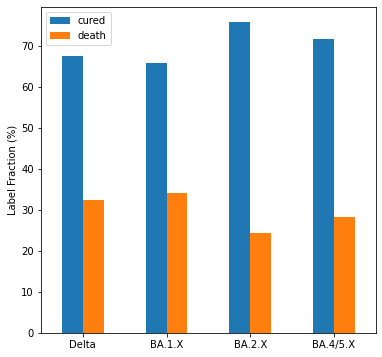

In [8]:
label_distribution(['cured','death'],['cured','death'],'outcome')

#### Secondary outcome: ICU

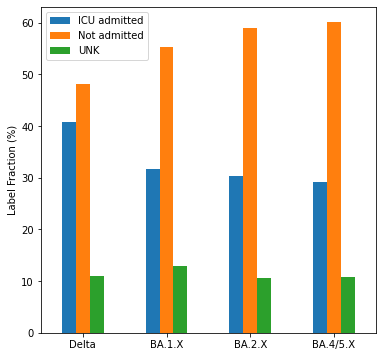

In [9]:
label_distribution([1,0,'UNK'],['ICU admitted','Not admitted','UNK'],'icu_adm')

#### Secondary outcome: invasive ventilation

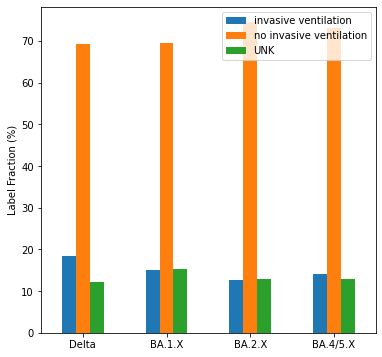

In [10]:
label_distribution([1,0,'UNK'],['invasive ventilation','no invasive ventilation','UNK'],'ventilation_invasive')

#### Secondary outcome: noninvasive ventilation

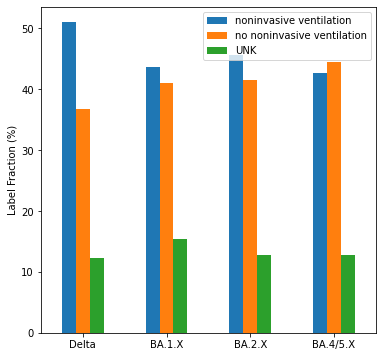

In [11]:
label_distribution([1,0,'UNK'],['noninvasive ventilation','no noninvasive ventilation','UNK'],'ventilation_noninvasive')

### Features vs. label

##### Cleaning data

In [12]:
# Function to show summary stats and distribution for a column
def show_distribution(var_data,nb_bins):
    from matplotlib import pyplot as plt

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print(var_data.name,'\nMinimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram   
    ax[0].hist(var_data,bins=nb_bins)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')

    # Add a title to the Figure
    fig.suptitle(var_data.name)

    # Show the figure
#    fig.show()

age 
Minimum:0.00
Mean:62.29
Median:68.00
Mode:0.00
Maximum:118.00

nb_comorbidities 
Minimum:0.00
Mean:1.03
Median:1.00
Mode:0.00
Maximum:4.00

nb_vaccine_dose 
Minimum:0.00
Mean:1.51
Median:2.00
Mode:2.00
Maximum:3.00

delay_lastdose_onset 
Minimum:-269.00
Mean:94.64
Median:122.00
Mode:-99.00
Maximum:36850.00

length_stay 
Minimum:0.00
Mean:11.30
Median:7.00
Mode:3.00
Maximum:832.00

length_delay 
Minimum:-796.00
Mean:4.74
Median:4.00
Mode:0.00
Maximum:337.00



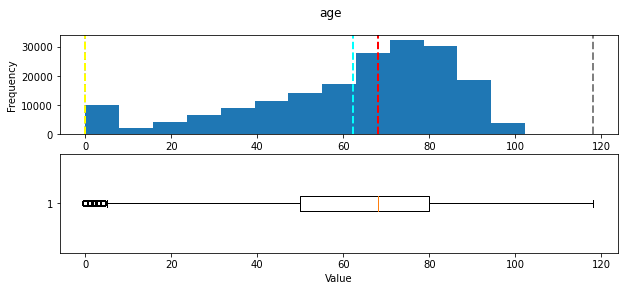

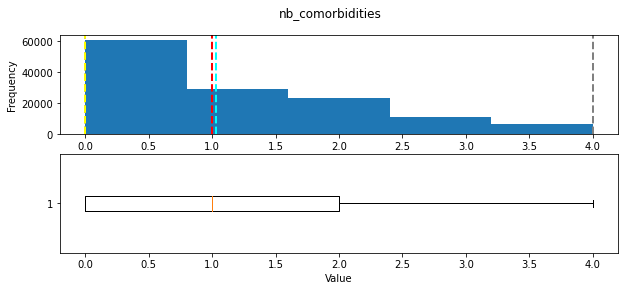

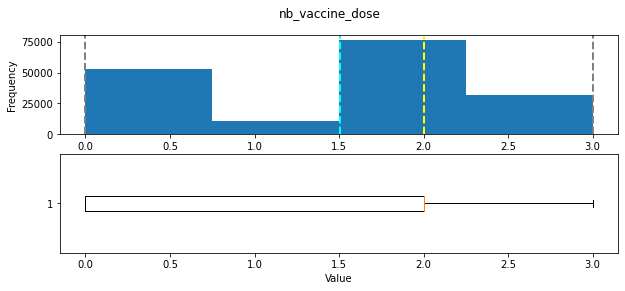

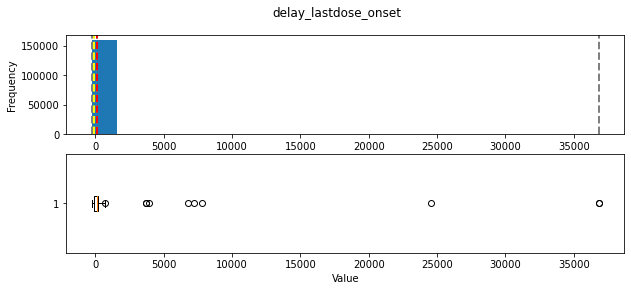

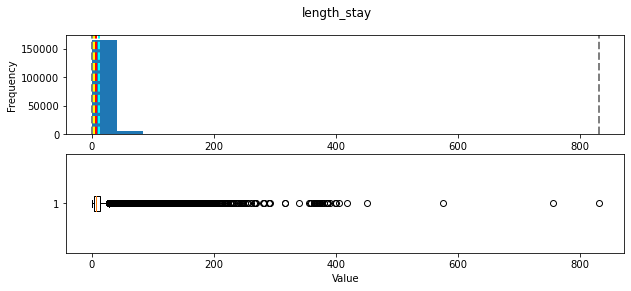

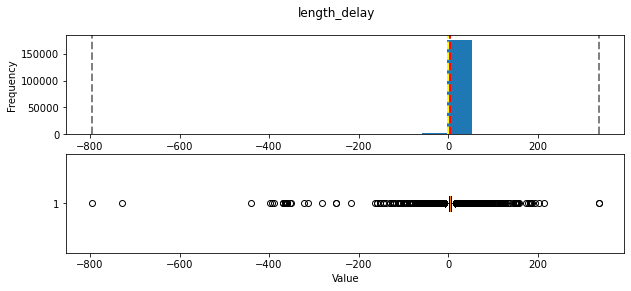

In [13]:
features_checked = ['age','nb_comorbidities','nb_vaccine_dose','delay_lastdose_onset','length_stay','length_delay']
nb_bins = [15,5,4,20,20,20]
for col in features_checked:
    show_distribution(df_analysis[df_analysis[col].notnull()][col],nb_bins[features_checked.index(col)])

**Clearly wrong dates (outliers) affect understanding of the figures**
- check how many of them they are, see if these wrong dates are systematic, apply possible correction
- if no generic correction applicable, simply set them to None

In [14]:
df_analysis.head()

,variant,age,age_group,sex,nb_comorbidities,cardiovascular_disease,hematologic_disease,down_syndrom,liver_disease,asthma,...,ethnicity,length_stay,length_delay,outcome,state,symptoms,icu_adm,ventilation_invasive,ventilation_noninvasive,pregnancy
0,Delta,52,4,Male,0,0.0,0.0,0.0,0.0,0.0,...,white,14.0,3.0,cured,SP,"persistent_cough,shortness_of_breath,low_o2_sa...",1,0,1,None
1,Delta,71,6,Female,3,1.0,0.0,0.0,0.0,0.0,...,None,6.0,3.0,death,CE,"shortness_of_breath,low_o2_sat, loss_of_appeti...",1,0,1,0
2,Delta,80,6,Male,None,NaN,NaN,NaN,NaN,NaN,...,white,7.0,7.0,cured,SP,"sore_throat,shortness_of_breath,low_o2_sat",0,0,1,None
3,Delta,89,6,Female,0,0.0,0.0,0.0,0.0,0.0,...,None,3.0,3.0,cured,SP,"shortness_of_breath,low_o2_sat,diarrhoea",1,None,None,0
4,Delta,56,5,Male,0,0.0,0.0,0.0,0.0,0.0,...,None,7.0,9.0,cured,DF,"fever,sore_throat,low_o2_sat, shortness_of_bre...",0,0,1,None


**delay_lastdose_onset**: vaccine rollout started January 7th 2021 in Brazil: maximum delay for each variant computed

**length_stay**: no strict rule to exclude outliers

In [15]:
for variant in variants_name:
    loc_data = df_analysis[df_analysis.variant==variant].copy()
    max_delay = (pd.to_datetime(variants_period[variants_name.index(variant)][1])-pd.to_datetime('2021-01-07')).days
    print(variant,'Nber wrong dates:',len(loc_data[loc_data.delay_lastdose_onset>max_delay]),'Sample size:',len(loc_data))
    print(variant,'Fraction length_stay greater than 50:',len(loc_data[loc_data.length_stay>30])/len(loc_data))
    print(variant,'Fraction length_delay greater than 50:',len(loc_data[loc_data.length_delay>30])/len(loc_data))

Delta Nber wrong dates: 3 Sample size: 48423
Delta Fraction length_stay greater than 50: 0.07409702001115173
Delta Fraction length_delay greater than 50: 0.0070627594325010845
BA.1.X Nber wrong dates: 15 Sample size: 113259
BA.1.X Fraction length_stay greater than 50: 0.06081635896485048
BA.1.X Fraction length_delay greater than 50: 0.004317537679124838
BA.2.X Nber wrong dates: 0 Sample size: 12737
BA.2.X Fraction length_stay greater than 50: 0.06728428986417524
BA.2.X Fraction length_delay greater than 50: 0.014524613331239696
BA.4/5.X Nber wrong dates: 1 Sample size: 12993
BA.4/5.X Fraction length_stay greater than 50: 0.05056568921727084
BA.4/5.X Fraction length_delay greater than 50: 0.0034634033710459478


**<u>Conclusion</u>**:
- no systematic error
- for delay, insignificant fraction of wrong dates

**<u>Solution</u>**: discard impossible value (set to None), keep the rest because of small statistical significance

In [16]:
for variant in variants_name:
    max_delay = (pd.to_datetime(variants_period[variants_name.index(variant)][1])-pd.to_datetime('2021-01-07')).days
    cond_correction = (df_analysis.variant==variant) & ((df_analysis.delay_lastdose_onset>max_delay) | (df_analysis.delay_lastdose_onset<0))
    df_analysis.delay_lastdose_onset = np.where(cond_correction,None,df_analysis.delay_lastdose_onset)
    cond_correction = (df_analysis.variant==variant) & (df_analysis.length_delay<0)
    df_analysis.length_delay = np.where(cond_correction,None,df_analysis.length_delay)

delay_lastdose_onset 
Minimum:0.00
Mean:189.45
Median:179.00
Mode:167.00
Maximum:575.00

length_stay 
Minimum:0.00
Mean:9.59
Median:7.00
Mode:3.00
Maximum:50.00

length_delay 
Minimum:0.00
Mean:4.93
Median:4.00
Mode:0.00
Maximum:50.00



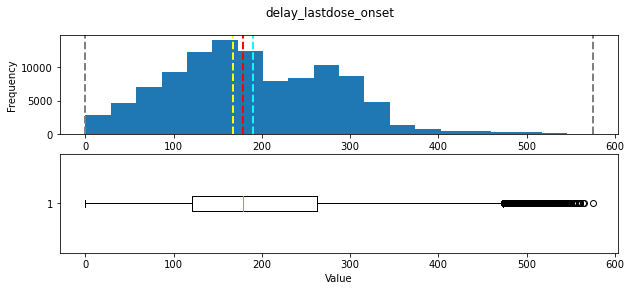

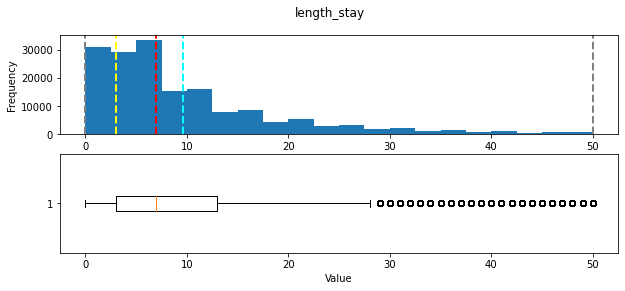

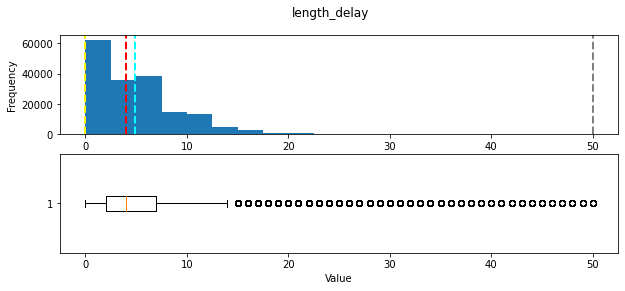

In [17]:
features_checked = ['delay_lastdose_onset','length_stay','length_delay']
nb_bins = [20,20,20]
for col in features_checked:
    if col == 'delay_lastdose_onset':
        show_distribution(df_analysis[df_analysis[col].notnull()][col],nb_bins[features_checked.index(col)])
    else:
        show_distribution(df_analysis[(df_analysis[col].notnull()) & (df_analysis[col]<=50)][col],nb_bins[features_checked.index(col)])

##### Cleaning nber of vaccine doses vs. age

Brazil included children aged 5 to 11 into their vaccination program in January 2022 and children aged 3 to 4 in July 2022. Any child under 12 years old and hospitalized before 15 January 2022 or less than 3 years old and hospitalized before 15 July 2022, if recorded as vaccinated will be considered as unvaccinated.

In [18]:
cond_correction = (data.DT_INTERNA<'2022-01-15') & (df_analysis.age<12) & (df_analysis.nb_vaccine_dose>0)
df_analysis.nb_vaccine_dose = np.where(cond_correction,0,df_analysis.nb_vaccine_dose)
cond_correction = (data.DT_INTERNA<'2022-07-15') & (df_analysis.age<3) & (df_analysis.nb_vaccine_dose>0)
df_analysis.nb_vaccine_dose = np.where(cond_correction,0,df_analysis.nb_vaccine_dose)

##### Features vs. Label

- ###### Continuous features

In [19]:
def func_boxplot(feat):
    fig, ax = plt.subplots(2, 2, figsize=(12,12))
    for variant in variants_name:
        loc_data = df_analysis[df_analysis.variant==variant].copy()
#to focus on where most values are
        if feat in ['length_stay','length_delay']:
            loc_data = loc_data[loc_data[feat]<=50].copy()            
        ax[fig_indices[variants_name.index(variant)][0]][fig_indices[variants_name.index(variant)][1]].boxplot([loc_data[(loc_data.outcome=='cured') & (loc_data[feat].notnull())][feat],
                                                      loc_data[(loc_data.outcome=='death') & (loc_data[feat].notnull())][feat]])
        ax[fig_indices[variants_name.index(variant)][0]][fig_indices[variants_name.index(variant)][1]].set_xticks([1,2])
        ax[fig_indices[variants_name.index(variant)][0]][fig_indices[variants_name.index(variant)][1]].set_xticklabels(['cured','death'])
        ax[fig_indices[variants_name.index(variant)][0]][fig_indices[variants_name.index(variant)][1]].set_ylabel(feat)
        ax[fig_indices[variants_name.index(variant)][0]][fig_indices[variants_name.index(variant)][1]].set_xlabel('Label')
        ax[fig_indices[variants_name.index(variant)][0]][fig_indices[variants_name.index(variant)][1]].set_title(variant)

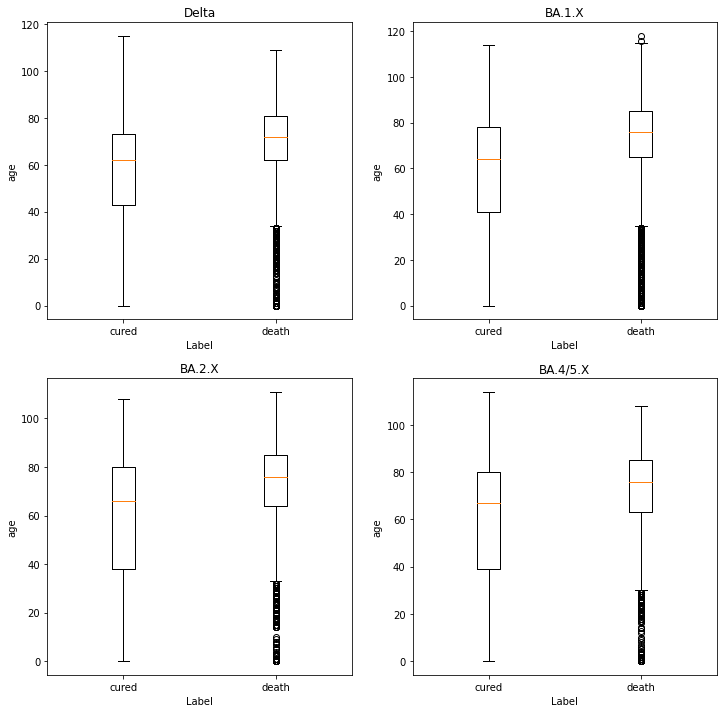

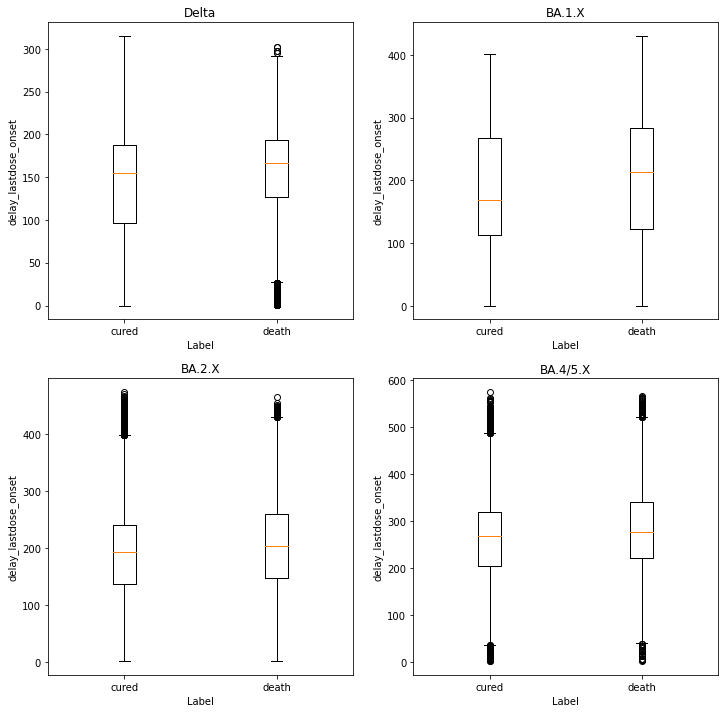

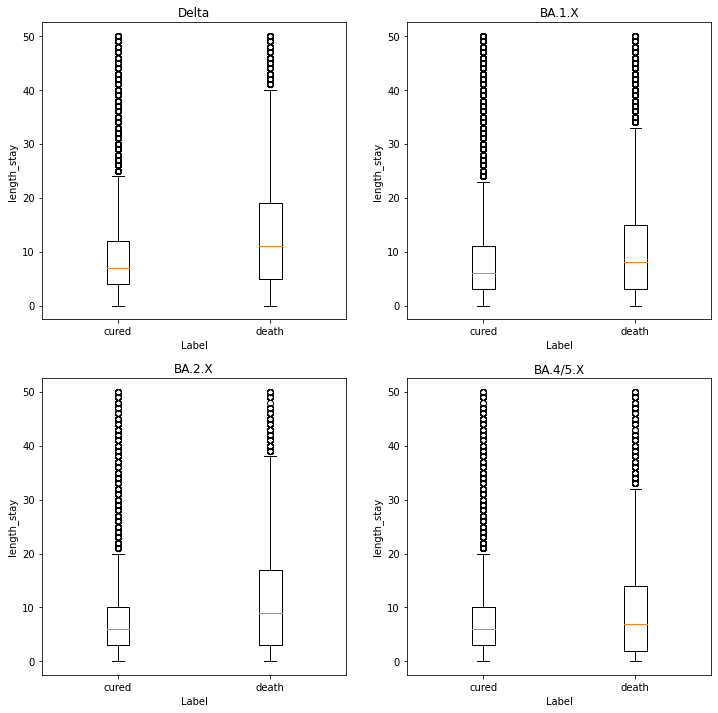

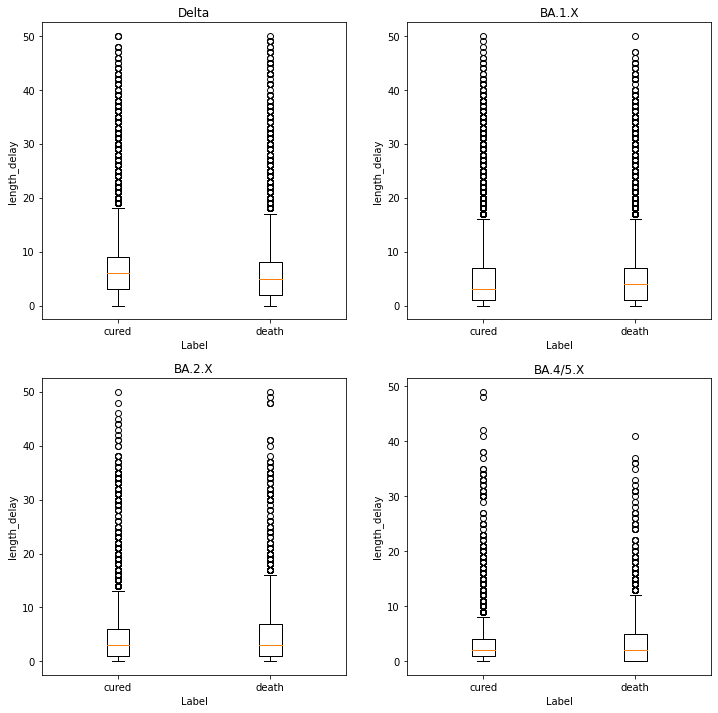

In [20]:
fig_indices = [[0,0],[0,1],[1,0],[1,1]]
features_boxplot = ['age','delay_lastdose_onset','length_stay','length_delay']

for feat in features_boxplot:
    func_boxplot(feat)

- ##### Categorical features

In [21]:
def func_histo(feat):
    feature = feat
    if feature != 'state':
        fig, axes = plt.subplots(2, 2, figsize=(12,12))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(24,24))
    index = ['cured','death']
    for variant in variants_name:
#ignore UNK values
        loc_data = df_analysis[(df_analysis.variant==variant) & (df_analysis[feature].notnull())].copy()
#        loc_data = df_analysis[df_analysis.variant==variant].copy()
        if None in loc_data[feature].where(pd.notnull(loc_data[feature]),None).unique():
            unique_values = sorted(loc_data[feature].dropna().unique())
            unique_values.append('UNK')
        else:
            unique_values = sorted(loc_data[feature].dropna().unique())
        nb_element_feat = [ [] for _ in range(len(unique_values)) ]
        for param in index:
            for element in nb_element_feat:
                if unique_values[nb_element_feat.index(element)] != 'UNK':
                    element.append(len(loc_data[(loc_data.outcome==param) & (loc_data[feature]==unique_values[nb_element_feat.index(element)])])/len(loc_data[loc_data[feature]==unique_values[nb_element_feat.index(element)]])*100.)
                else:
                    element.append(len(loc_data[(loc_data.outcome==param) & (loc_data[feature].isnull())])/len(loc_data[loc_data[feature].isnull()])*100.)                            
        df = pd.DataFrame(index=index)
        for element in nb_element_feat:
            df[unique_values[nb_element_feat.index(element)]] = element
        df.plot.bar(ax=axes[fig_indices[variants_name.index(variant)][0]][fig_indices[variants_name.index(variant)][1]],rot=0,ylabel=feat+r' fraction (%)',title=variant)
    plt.show()
    plt.close()

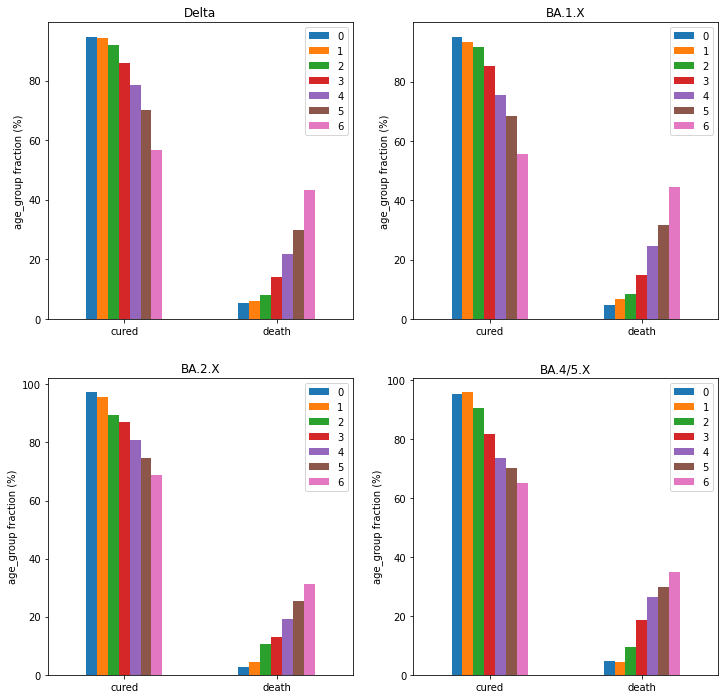

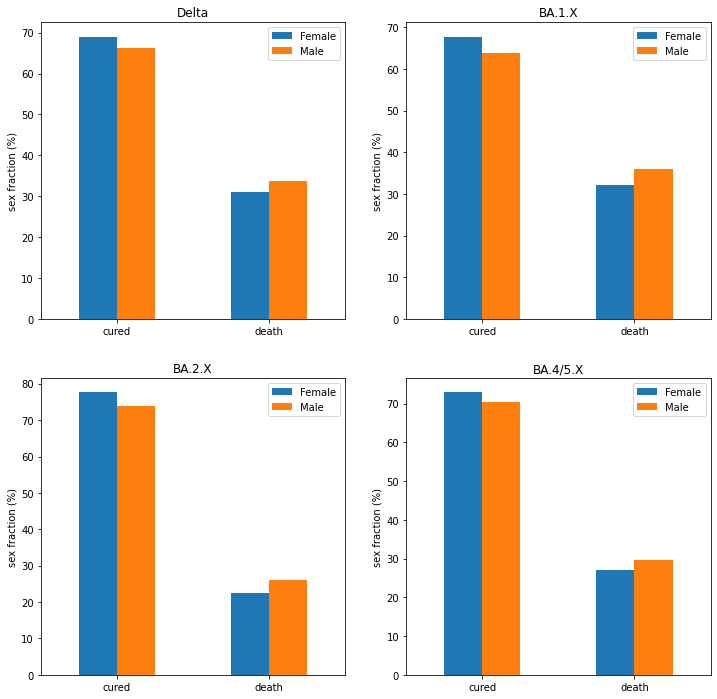

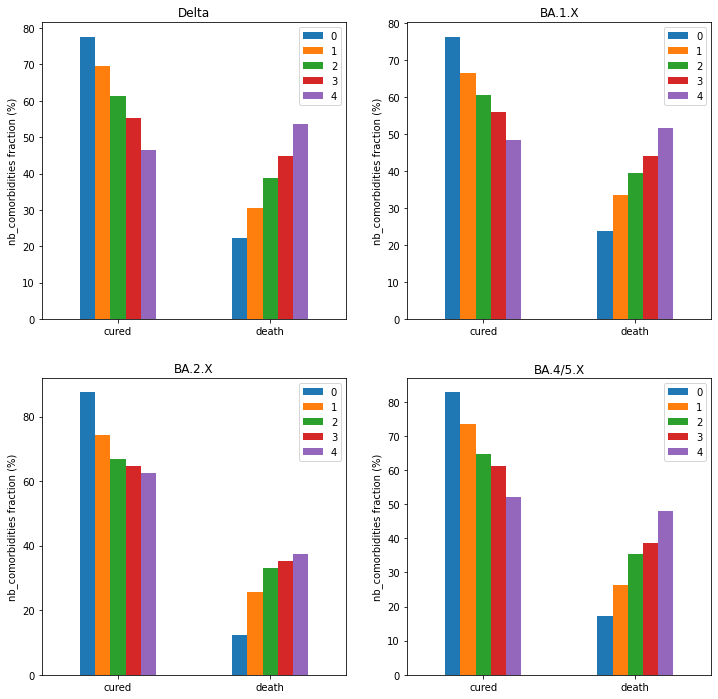

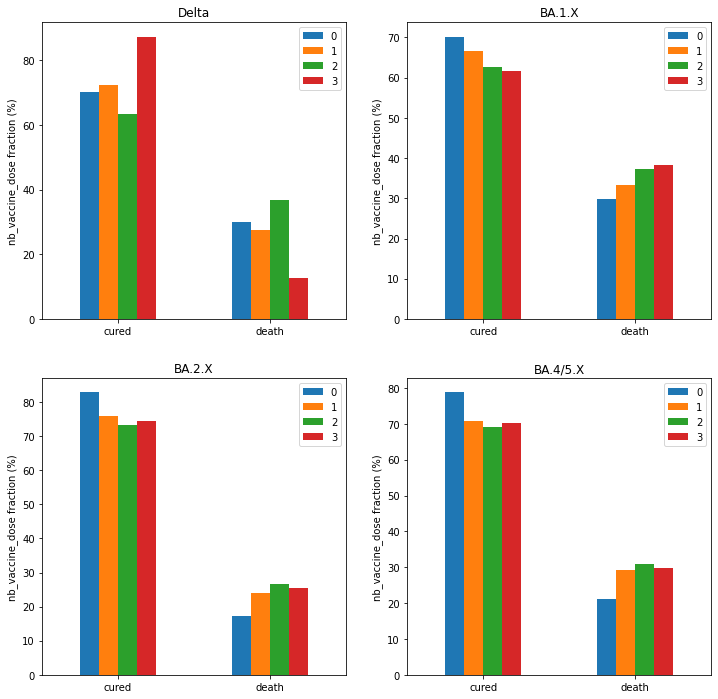

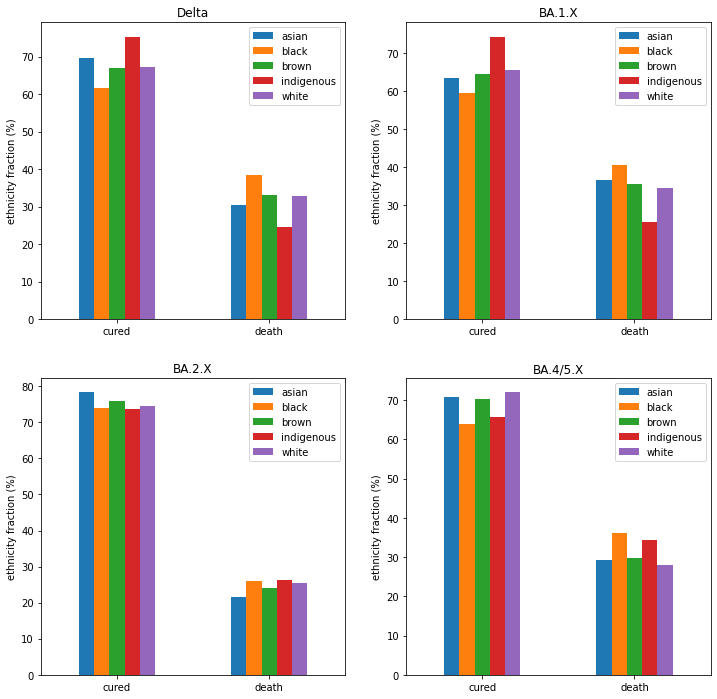

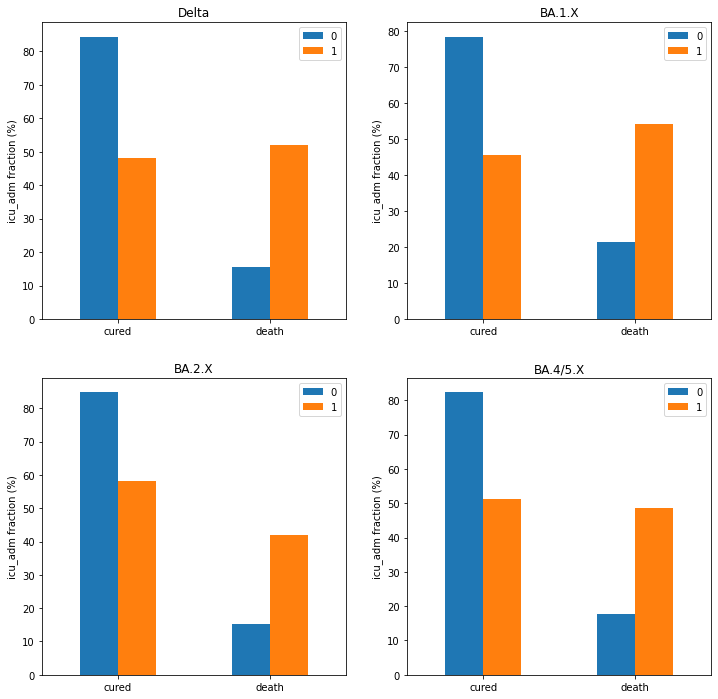

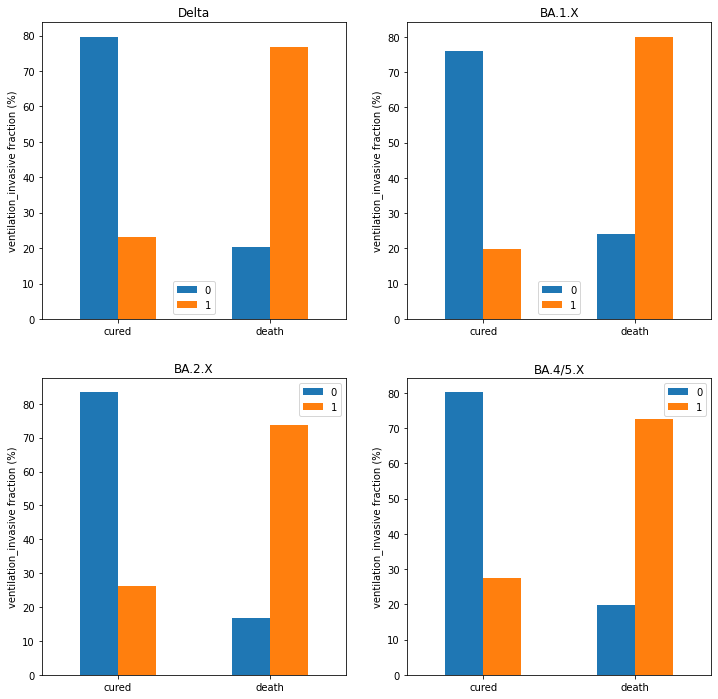

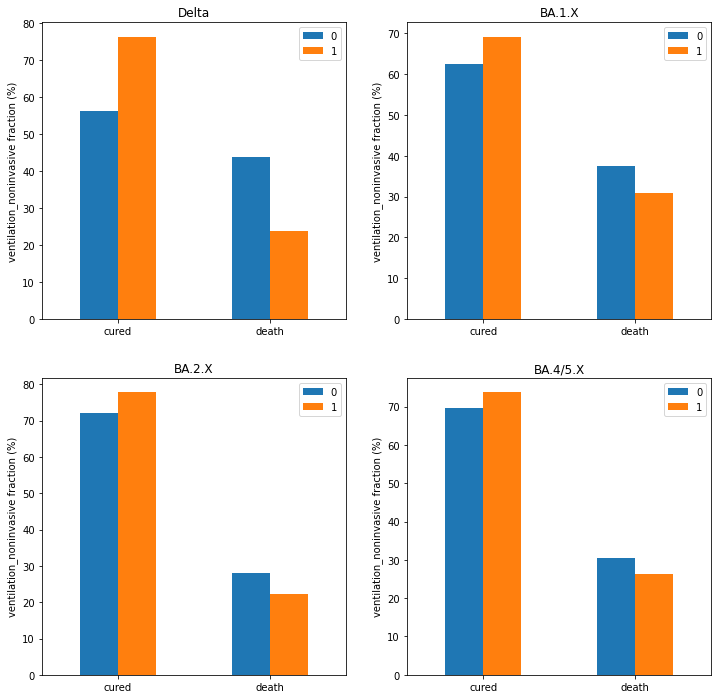

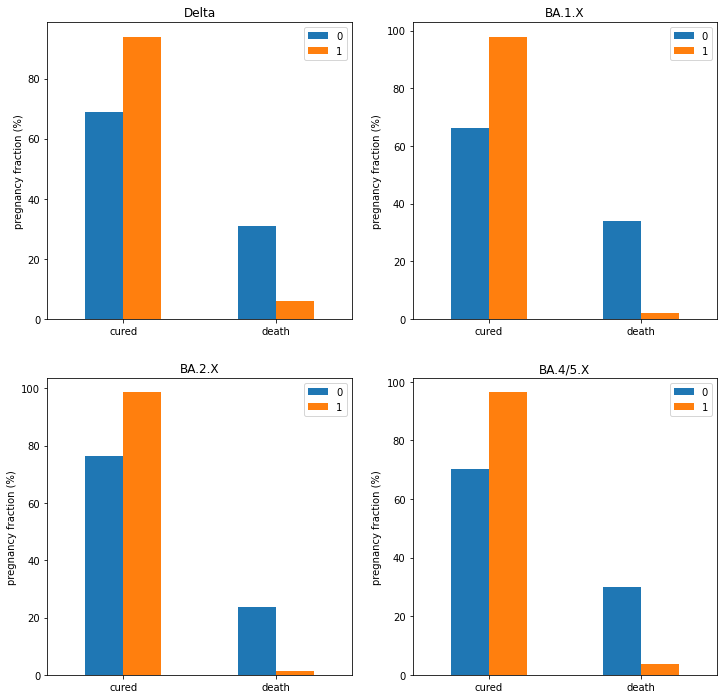

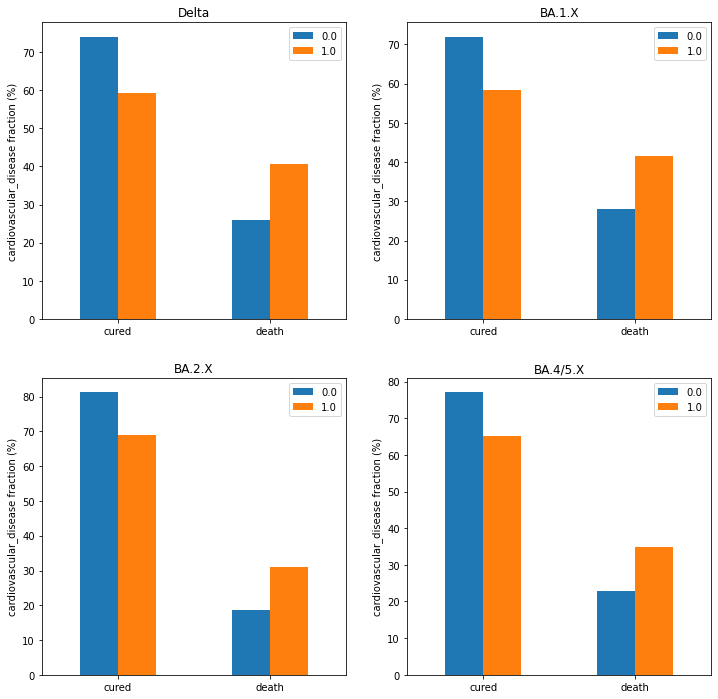

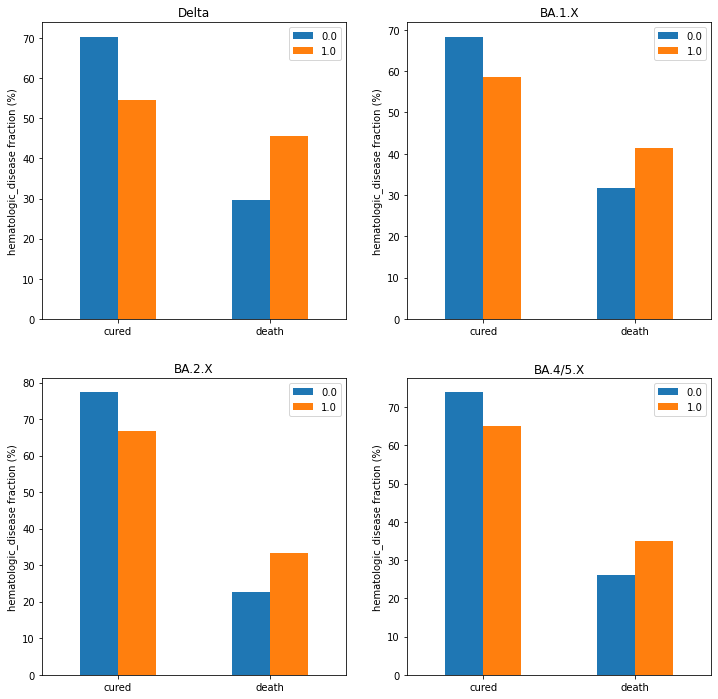

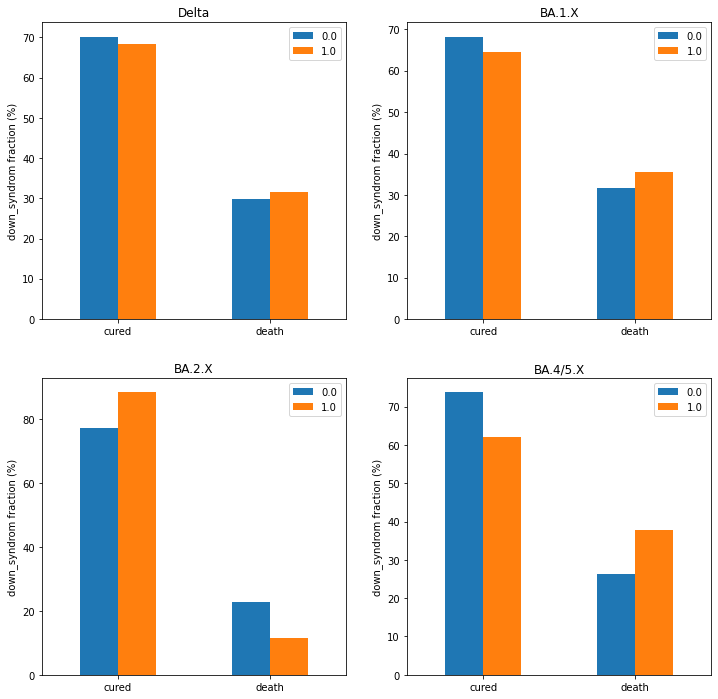

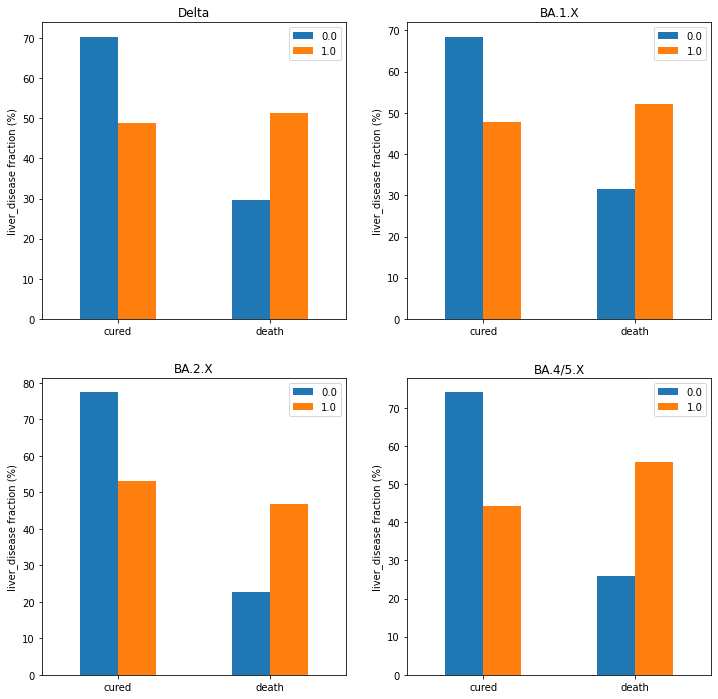

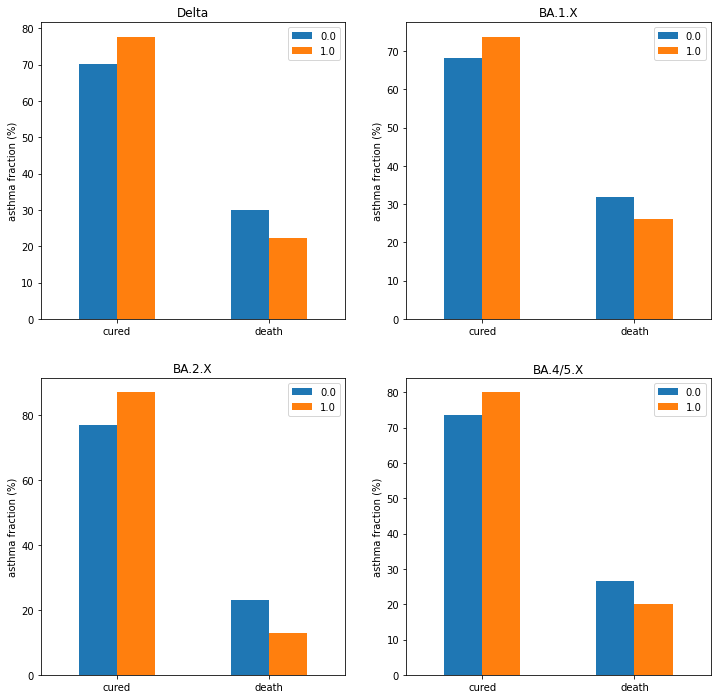

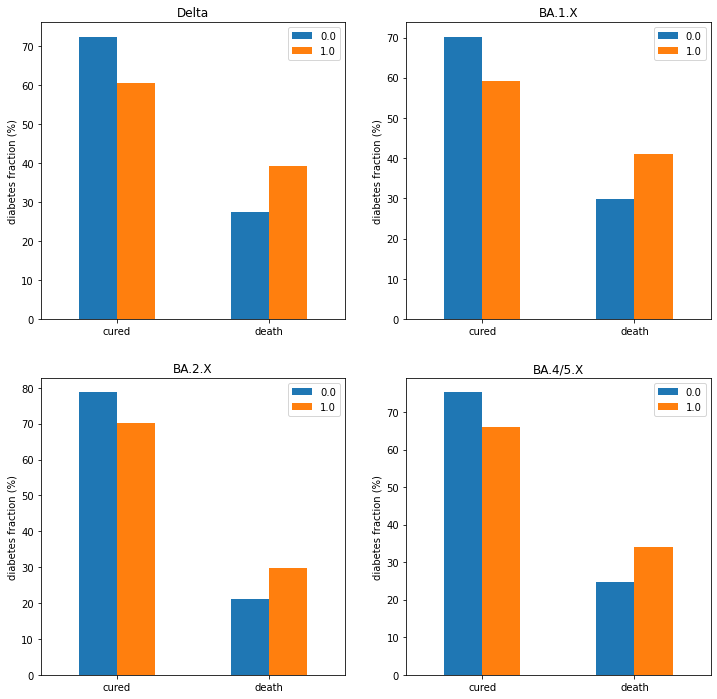

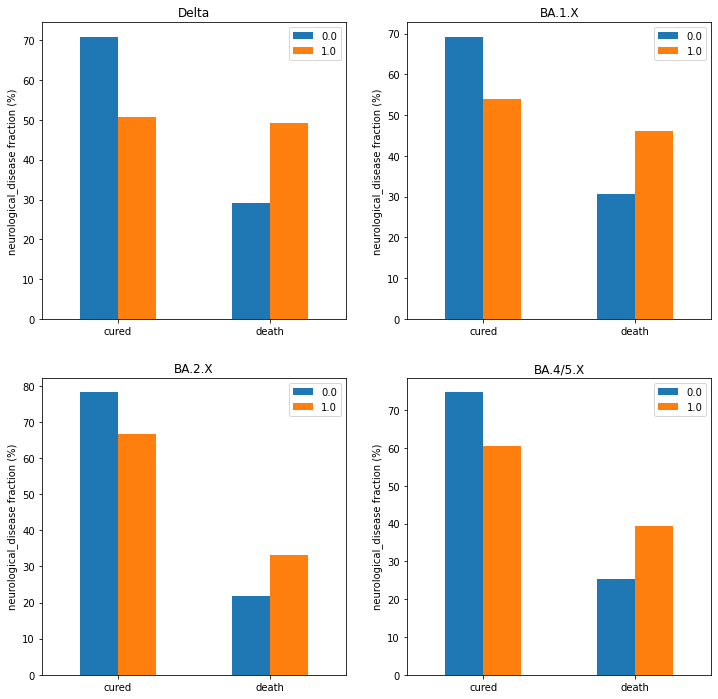

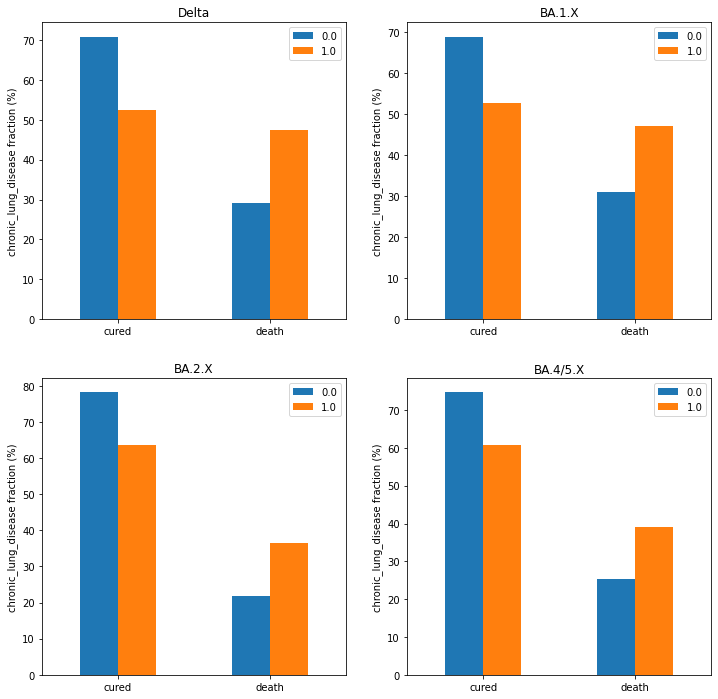

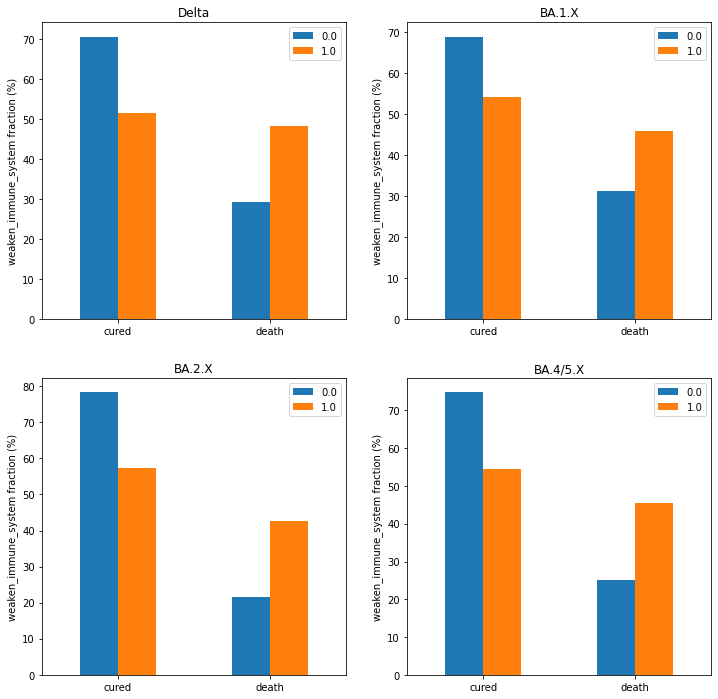

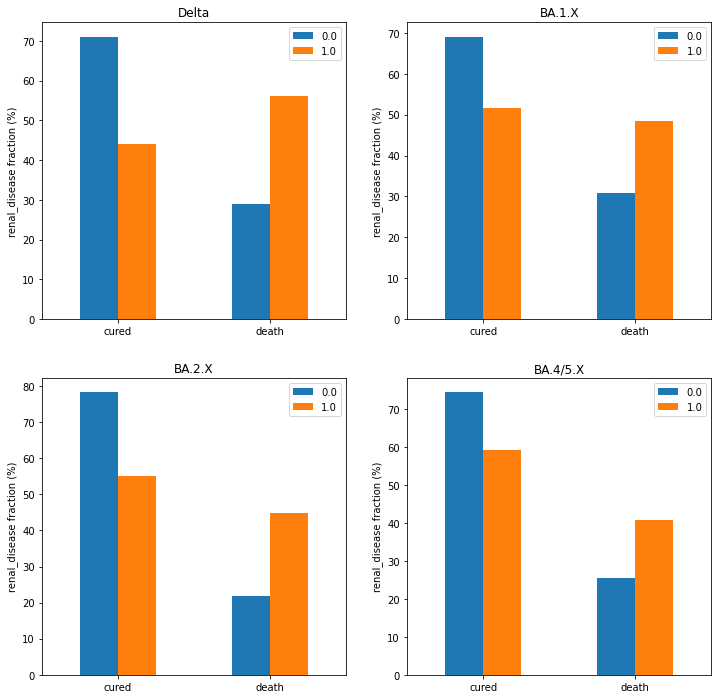

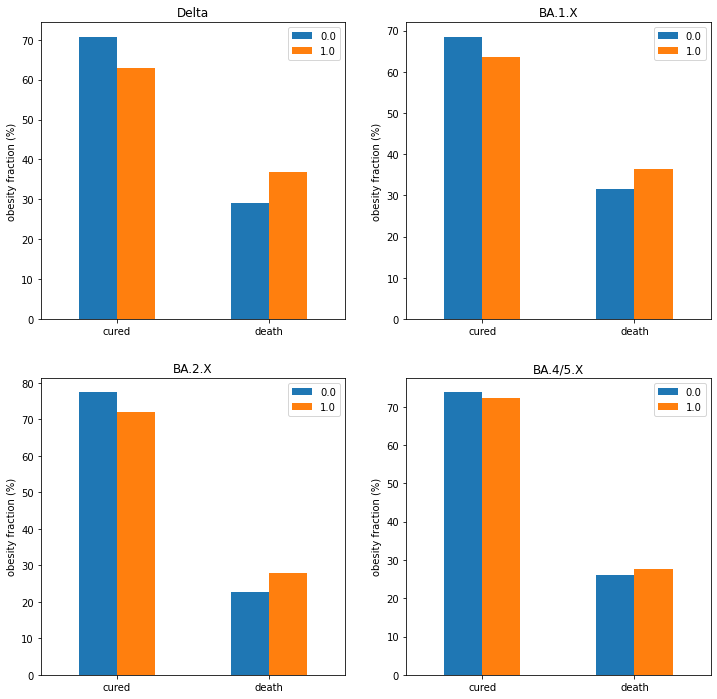

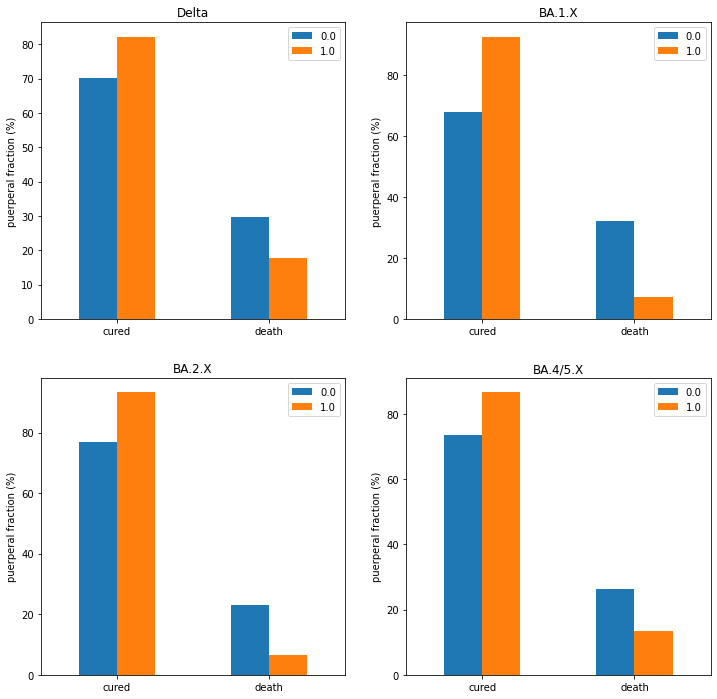

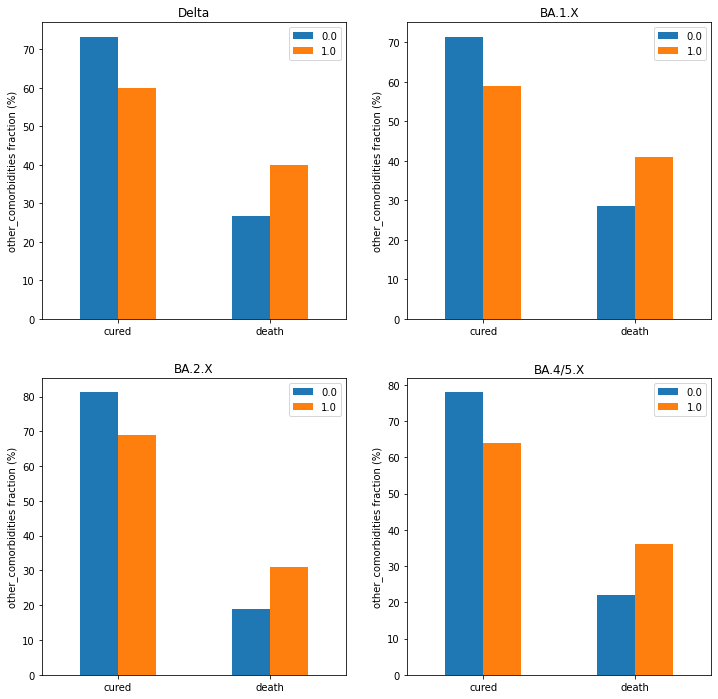

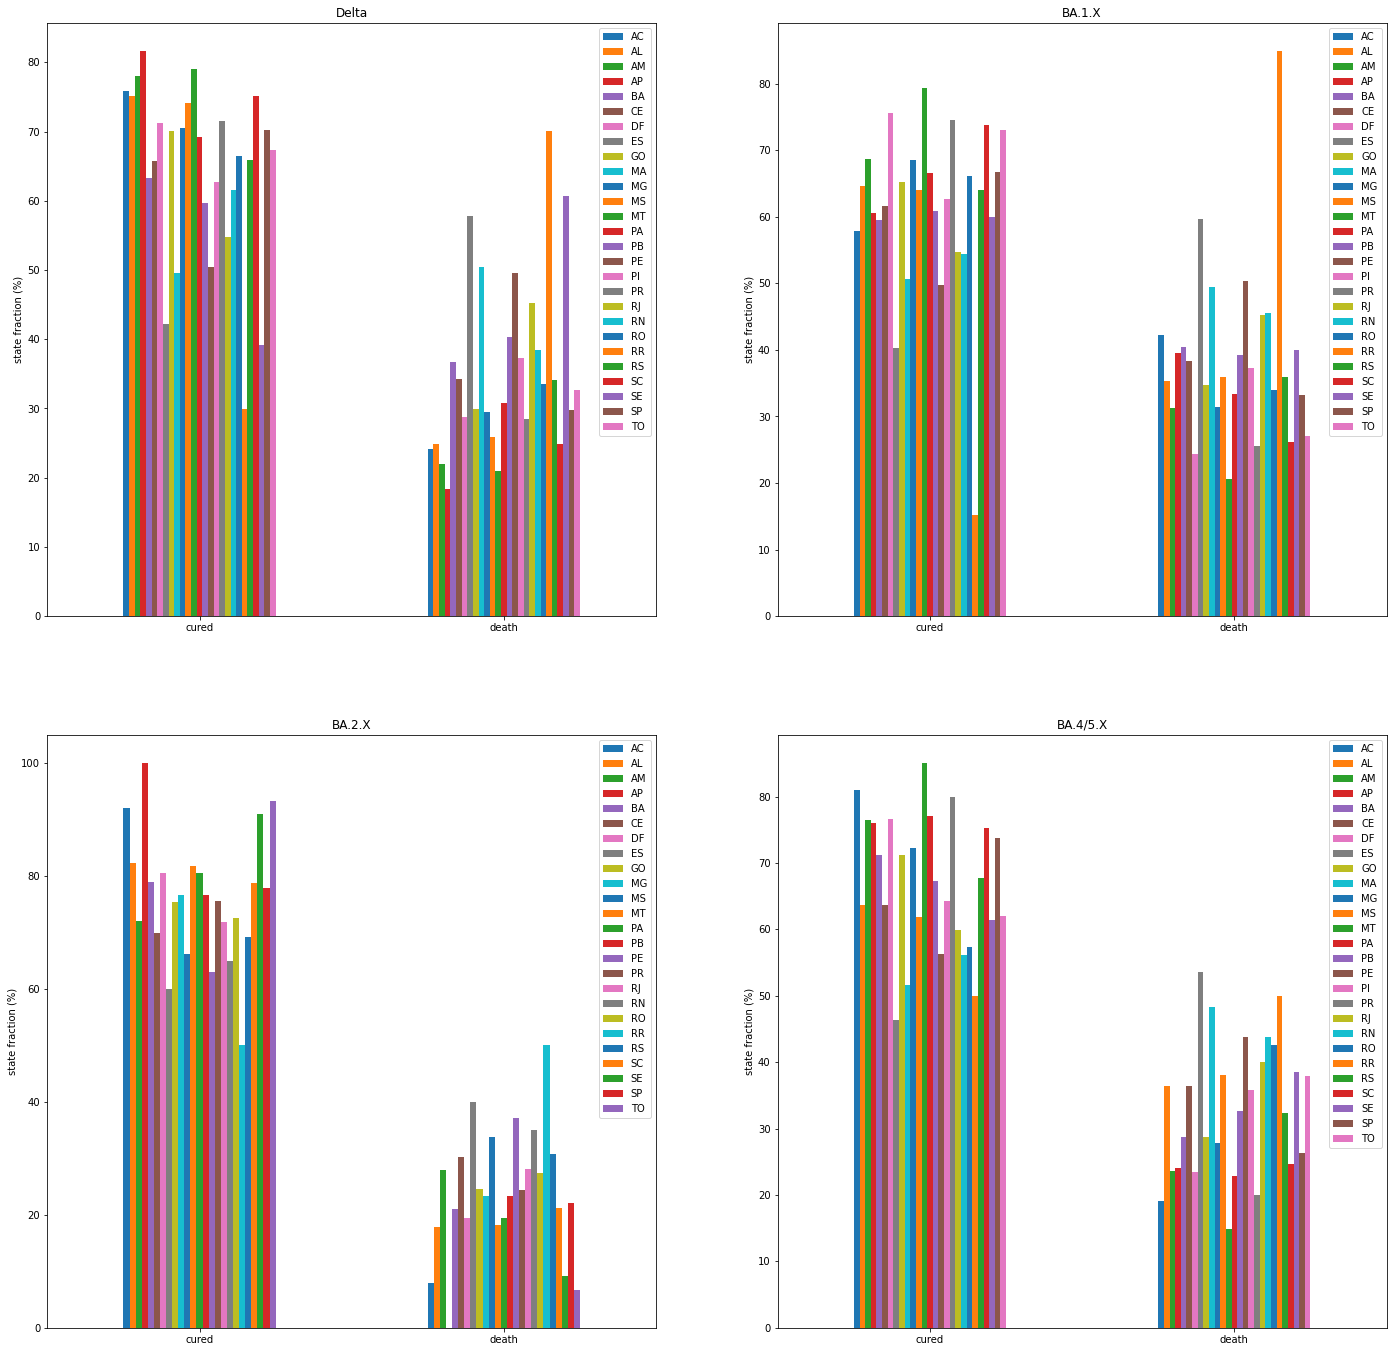

In [22]:
features_histo = ['age_group','sex','nb_comorbidities','nb_vaccine_dose','ethnicity','icu_adm','ventilation_invasive',
                  'ventilation_noninvasive','pregnancy','cardiovascular_disease','hematologic_disease','down_syndrom',
                  'liver_disease','asthma','diabetes','neurological_disease','chronic_lung_disease',
                  'weaken_immune_system','renal_disease','obesity','puerperal','other_comorbidities','state']
fig_indices = [[0,0],[0,1],[1,0],[1,1]]
for feat in features_histo:
    func_histo(feat)

## Basic observations:

- mortality increases with age (as expected/known)
- slight difference between male/female outcome across variants
- mortality increases with number of comorbidities (as expected/known)
- some effect of vaccine on mortality for Delta, no effect observed for other variants: careful to disentangle the effect of all parameters (see notebook with logistic regression)
- mortality clearly related to ICU admission/invasive ventilation (as expected/known)

## Set up data for further analysis (e.g., Machine Learning algorithm)

- Replace categorical variables by dummy variables

In [23]:
categorical_var_to_dummy = ['age_group','variant','sex','ethnicity','state','nb_comorbidities','nb_vaccine_dose']
for feature in categorical_var_to_dummy:
    dummy = pd.get_dummies(df_analysis[[feature]])
    if feature != categorical_var_to_dummy[0]:
        df_encoded = df_encoded.drop([feature],1)
        df_encoded = pd.concat([df_encoded,dummy], axis=1)
    else:
        df_encoded = df_analysis.drop([feature],1)
        df_encoded = pd.concat([df_encoded,dummy], axis=1)
dummy_symptoms_uncorrected = df_analysis['symptoms'].str.get_dummies(sep=',')
dummy_symptoms = pd.DataFrame()
for symptom in dummy_symptoms_uncorrected.columns.str.strip().unique():
    dummy_symptoms[symptom] = dummy_symptoms_uncorrected[dummy_symptoms_uncorrected.columns[dummy_symptoms_uncorrected.columns.str.contains(symptom)]].sum(axis=1)
for symptom in dummy_symptoms.columns:
    cond = dummy_symptoms[symptom]>1
    dummy_symptoms[symptom] = np.where(cond,1,dummy_symptoms[symptom])
dummy_symptoms = dummy_symptoms.rename(columns={"asthma":"asthma_symptom"})
df_encoded = df_encoded.drop(['symptoms'],axis=1)
df_encoded = pd.concat([df_encoded,dummy_symptoms], axis=1)

In [24]:
df_encoded.outcome = df_encoded.outcome.replace('cured',0).replace('death',1)

In [25]:
df_encoded.to_parquet('encoded_severe_cases_data.pq')